In [61]:
#!pip install --upgrade pandas matplotlib

#!pip install xgboost

## 1.Entendimento do Negócio

O objetivo é projetar e avaliar um modelo de detecção de fraude em transações de cartão em tempo real, potencialmente integrável ao motor de decisão da Vom.
A métrica que queremos otimizar é a recorrencia,pois aprovar uma fraude é mais custoso que negar indevidamente uma transaçao legitima.

## 2.Entendimento dos dados

In [47]:
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from sklearn.metrics import precision_recall_curve,auc
from sklearn.linear_model import LogisticRegression


In [3]:
dados = pd.read_csv('dataset.csv')
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
 #   Column                          Non-Null Count    Dtype  
---  ------                          --------------    -----  
 0   distance_from_home              1000000 non-null  float64
 1   distance_from_last_transaction  1000000 non-null  float64
 2   ratio_to_median_purchase_price  1000000 non-null  float64
 3   repeat_retailer                 1000000 non-null  float64
 4   used_chip                       1000000 non-null  float64
 5   used_pin_number                 1000000 non-null  float64
 6   online_order                    1000000 non-null  float64
 7   fraud                           1000000 non-null  float64
dtypes: float64(8)
memory usage: 61.0 MB


### Nao existem dados nulos
### Estatísticas descritivas para colunas numéricas

In [4]:
estatisticas_numericas = pd.DataFrame(dados.describe())
estatisticas_numericas



,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,26.628792,5.036519,1.824182,0.881536,0.350399,0.100608,0.650552,0.087403
std,65.390784,25.843093,2.799589,0.323157,0.477095,0.300809,0.476796,0.282425
min,0.004874,0.000118,0.004399,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.878008,0.296671,0.475673,1.000000,0.000000,0.000000,0.000000,0.000000
50%,9.967760,0.998650,0.997717,1.000000,0.000000,0.000000,1.000000,0.000000
75%,25.743985,3.355748,2.096370,1.000000,1.000000,0.000000,1.000000,0.000000
max,10632.723672,11851.104565,267.802942,1.000000,1.000000,1.000000,1.000000,1.000000


### Estatísticas descritivas para colunas categóricas

In [16]:
contagens=[]
colunas_categoricas = ['repeat_retailer', 'used_chip', 'used_pin_number', 'online_order', 'fraud']
import pandas as pd


contagens_novas = []
for col in colunas_categoricas:
    
    contagem_abs = dados[col].value_counts().rename('Contagem')
    contagem_rel = dados[col].value_counts(normalize=True).mul(100).rename('Porcentagem (%)').round(2)
    df_temp = pd.concat([contagem_abs, contagem_rel], axis=1)
    df_temp['Variável'] = col
    df_temp = df_temp.reset_index()
    contagens_novas.append(df_temp)


print("### Distribuição de Frequência para Colunas Booleanas/Categóricas (Formato de Tabela) ###\n")
resumo_categorico_tabela = pd.concat(contagens_novas)[['Variável', 'Contagem', 'Porcentagem (%)']]
print(resumo_categorico_tabela)

### Distribuição de Frequência para Colunas Booleanas/Categóricas (Formato de Tabela) ###

          Variável  Contagem  Porcentagem (%)
0  repeat_retailer    881536            88.15
1  repeat_retailer    118464            11.85
0        used_chip    649601            64.96
1        used_chip    350399            35.04
0  used_pin_number    899392            89.94
1  used_pin_number    100608            10.06
0     online_order    650552            65.06
1     online_order    349448            34.94
0            fraud    912597            91.26
1            fraud     87403             8.74


### Podemos ver que o conjunto de dados é bastante desbalanceado,com apenas 8.7% de transaçoes fraudulentas

### Distribuiçoes e Correlaçoes

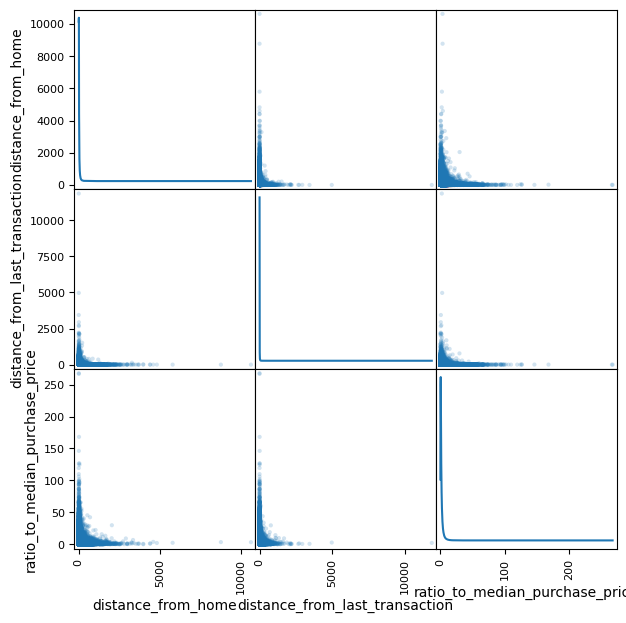

In [54]:
scatter_matrix(dados[['distance_from_home','distance_from_last_transaction','ratio_to_median_purchase_price']], alpha=0.2, figsize=(7,7), diagonal='kde');

### Nao foi percebida nenhuma correlaçao entre variáveis

## 3.Preparaçao dos dados

### Nao existem dados ausentes e nao é necessario fazer normalizaçao dos dados,pois vou usar modelos que nao tem essa necessidade. 
### Também nao foram identificadas variáveis correlacionadas para serem removidas e nao existem variaveis categoricas onde seria necessaria a codificaçao

## 4.Modelagem

In [29]:
# 1. Definir Features (X) e Target (y)
X = dados.drop('fraud', axis=1) 
y = dados['fraud']              

# 2. Divisão dos Dados em Treino e Teste
# Usamos stratify=y para garantir que a proporção de fraudes seja a mesma nos 
# conjuntos de treino e teste, o que é crucial em dados desbalanceados.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)
print("Dados divididos em Treino e Teste (70/30).")



Dados divididos em Treino e Teste (70/30).
Scale_pos_weight (0/1): 10.44

Iniciando o treinamento do modelo XGBoost...


/opt/conda/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [14:39:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Treinamento concluído!


### Regressao Log

In [57]:
# 1. Inicializar o Classificador de Regressão Logística
# O parâmetro 'class_weight='balanced'' automaticamente ajusta os pesos 
# para compensar o desbalanceamento de classes, dando mais peso à classe minoritária (fraude).
logreg_model = LogisticRegression(
    solver='liblinear',  # Bom para pequenos datasets e L2/L1 penalidade
    class_weight='balanced',
    random_state=42,
    max_iter=1000 # Aumentar o máximo de iterações pode ser necessário para convergência
)

# 2. Treinar o Modelo
print("Iniciando o treinamento do modelo de Regressão Logística...")
logreg_model.fit(X_train, y_train)
print("Treinamento concluído!")

# 3. Fazer Previsões
# y_pred (predições binárias usando o limiar padrão de 0.5)
y_pred = logreg_model.predict(X_test) 
# y_proba (probabilidades para calcular AUC-ROC)
y_proba = logreg_model.predict_proba(X_test)[:, 1] 



Iniciando o treinamento do modelo de Regressão Logística...
Treinamento concluído!


### Metricas de Desempenho

In [58]:
# 1. Avaliar o Desempenho

print("Relatório de Métricas - Regressão Logística")
print("-" * 50)

# 2. AUC-ROC Score (Mede a capacidade de distinguir as classes)
auc_roc_score = roc_auc_score(y_test, y_proba)
print(f"AUC-ROC Score: {auc_roc_score:.4f}")

# 3. Relatório de Classificação (Precision, Recall, F1-Score)
print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred))

# 4. Matriz de Confusão (Representação de acertos e erros)

# 4.1. Gerar a Matriz de Confusão (Array NumPy)
cm = confusion_matrix(y_test, y_pred)

# 4.2. Extrair os valores
# TN (True Negative), FP (False Positive), FN (False Negative), TP (True Positive)
TN, FP, FN, TP = cm.ravel()

# 4.3. Criar o DataFrame com Rótulos e Anotações
df_cm = pd.DataFrame(
    # Os valores da matriz
    [[f"{TN} (TN)", f"{FP} (FP)"],
     [f"{FN} (FN)", f"{TP} (TP)"]],
    
    # Nomes das Linhas (Valores Reais)
    index=['Real 0 (Não-Fraude)', 'Real 1 (Fraude)'],
    
    # Nomes das Colunas (Valores Preditos)
    columns=['Predito 0 (Não-Fraude)', 'Predito 1 (Fraude)']
)

print("Matriz de Confusão Rotulada (Regressão Logística)")
print(df_cm)

Relatório de Métricas - Regressão Logística
--------------------------------------------------
AUC-ROC Score: 0.9796

Relatório de Classificação:
              precision    recall  f1-score   support

         0.0       0.99      0.93      0.96    273779
         1.0       0.58      0.95      0.72     26221

    accuracy                           0.93    300000
   macro avg       0.79      0.94      0.84    300000
weighted avg       0.96      0.93      0.94    300000

Matriz de Confusão Rotulada (Regressão Logística)
                    Predito 0 (Não-Fraude) Predito 1 (Fraude)
Real 0 (Não-Fraude)            255481 (TN)         18298 (FP)
Real 1 (Fraude)                  1354 (FN)         24867 (TP)


### Xgboost

In [59]:

# Calcular o ratio para balanceamento (essencial para detecção de fraude)
# É a proporção de amostras negativas (0) para amostras positivas (1)
neg_count = y_train.value_counts()[0]
pos_count = y_train.value_counts()[1]
scale_pos_weight_value = neg_count / pos_count
print(f"Scale_pos_weight (0/1): {scale_pos_weight_value:.2f}")

# 3. Inicializar o Classificador XGBoost
xgb_model = XGBClassifier(
    objective='binary:logistic',  # Para problemas de classificação binária
    n_estimators=100,             # Número de árvores
    learning_rate=0.1,            # Taxa de aprendizado
    scale_pos_weight=scale_pos_weight_value, # Tratamento do desbalanceamento
    use_label_encoder=False,      # Recomendado para versões mais recentes do XGBoost
    eval_metric='logloss',        # Métrica de avaliação
    random_state=42
)

# 4. Treinar o Modelo
print("\nIniciando o treinamento do modelo XGBoost...")
xgb_model.fit(X_train, y_train)
print("Treinamento concluído!")


# 5. Fazer Previsões no Conjunto de Teste
y_pred = xgb_model.predict(X_test)



Scale_pos_weight (0/1): 10.44

Iniciando o treinamento do modelo XGBoost...


/opt/conda/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [18:12:58] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Treinamento concluído!


### Metricas de desempenho

In [60]:
# 1. Avaliar o Desempenho
print("\n## Relatório de Classificação e Métricas ##")

# Relatório Completo (precisão, recall, f1-score)
print(classification_report(y_test, y_pred))


# Matriz de Confusão (visualização de acertos e erros)

# 1. Gerar a Matriz de Confusão (Array NumPy)
cm = confusion_matrix(y_test, y_pred)

# 2. Extrair os valores
# TN (True Negative), FP (False Positive), FN (False Negative), TP (True Positive)
TN, FP, FN, TP = cm.ravel()

# 3. Criar o DataFrame com Rótulos e Anotações
df_cm = pd.DataFrame(
    # Os valores da matriz
    [[f"{TN} (TN)", f"{FP} (FP)"],
     [f"{FN} (FN)", f"{TP} (TP)"]],
    
    # Nomes das Linhas (Valores Reais)
    index=['Real 0 (Não-Fraude)', 'Real 1 (Fraude)'],
    
    # Nomes das Colunas (Valores Preditos)
    columns=['Predito 0 (Não-Fraude)', 'Predito 1 (Fraude)']
)

print("Matriz de Confusão Rotulada (Xgboost)")
print(df_cm)


## Relatório de Classificação e Métricas ##
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    273779
         1.0       0.98      1.00      0.99     26221

    accuracy                           1.00    300000
   macro avg       0.99      1.00      0.99    300000
weighted avg       1.00      1.00      1.00    300000

Matriz de Confusão Rotulada (Xgboost)
                    Predito 0 (Não-Fraude) Predito 1 (Fraude)
Real 0 (Não-Fraude)            273107 (TN)           672 (FP)
Real 1 (Fraude)                     6 (FN)         26215 (TP)


### Curva PR-AUC

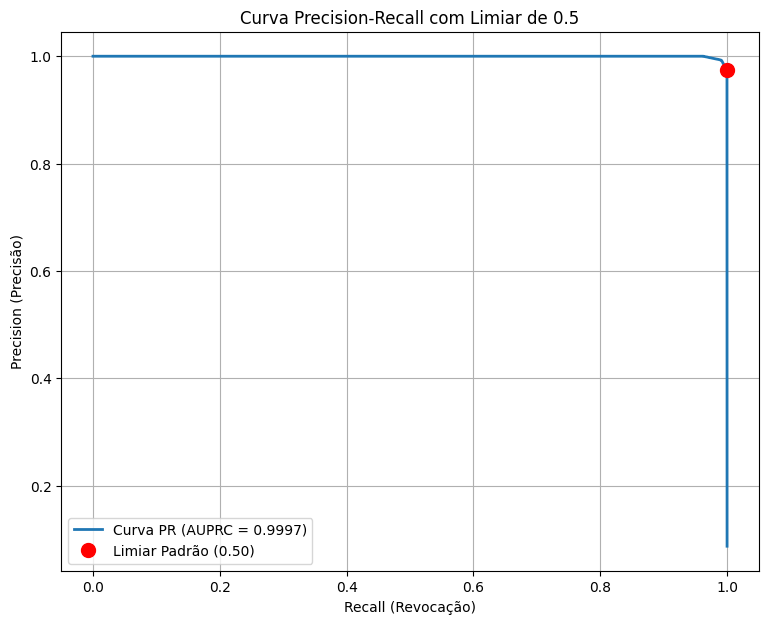


--- Limiares ---
Limiar de Decisão Padrão do XGBoost: 0.50
Precisão com limiar 0.50: 0.9750
Recall com limiar 0.50: 0.9998


In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc

# 1. Calcular a Curva Precision-Recall
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
auprc_score = auc(recall, precision)

# 2. Localizar o Ponto de Desempenho para o Limiar Padrão (0.5)
# O limiar 0.5 é o que o modelo usa por padrão para fazer a predição binária (y_pred)
limiar_padrao = 0.5

# Encontra o índice da primeira ocorrência do limiar >= 0.5
# O valor de precision/recall no índice 'idx' corresponde ao threshold no índice 'idx-1'.
idx_limiar = np.argmin(np.abs(thresholds - limiar_padrao))

# Os valores de precisão e recall neste índice
recall_no_limiar = recall[idx_limiar]
precision_no_limiar = precision[idx_limiar]


# 3. Gerar o Gráfico
plt.figure(figsize=(9, 7))
plt.plot(recall, precision, label=f'Curva PR (AUPRC = {auprc_score:.4f})', linewidth=2)

# Adicionar o ponto do limiar padrão de 0.5
plt.plot(recall_no_limiar, precision_no_limiar, 'o', markersize=10, 
         color='red', label=f'Limiar Padrão ({limiar_padrao:.2f})')

plt.xlabel('Recall (Revocação)')
plt.ylabel('Precision (Precisão)')
plt.title('Curva Precision-Recall com Limiar de 0.5')
plt.legend(loc="lower left")
plt.grid(True)
plt.show()


# Imprimir o Limiar Padrão
print("\n--- Limiares ---")
print(f"Limiar de Decisão Padrão do XGBoost: {limiar_padrao:.2f}")

# Imprimir o desempenho (Precisão e Recall) obtido com esse limiar
print(f"Precisão com limiar {limiar_padrao:.2f}: {precision_no_limiar:.4f}")
print(f"Recall com limiar {limiar_padrao:.2f}: {recall_no_limiar:.4f}")

## 5.Avaliaçao

### O modelo com regressao log obteve recorrencia de 0.95 e o modelo Xgboost 0.99, entao eu escolheria o Xgboost para colocar em produçao por ter a maior recorrencia
### Diminuir o Limiar: Aumenta a sensibilidade do modelo. Isso aumenta o Recall (↓FN) e, geralmente, diminui a Precisão (↑FP). O ponto de desempenho se move para baixo e para a direita no gráfico PR.

### Aumentar o Limiar: Aumenta a seletividade/rigor do modelo. Isso aumenta a Precisão (↓FP) e, geralmente, diminui o Recall (↑FN). O ponto de desempenho se move para cima e para a esquerda no gráfico PR.

### Faz sentido usar esse modelo,embora seja menos explicavel que a regressao log ele teve o melhor desempenho,que é o mais importante aqui

## 6.Colocar em Produçao/Monitoramento

### Colocar em produçao(AWS)

### 1.Criação do Modelo (Model): Registre seu modelo treinado (artefatos) e a imagem Docker do container de inferência (que contém seu código de servidor web) no SageMaker.

### 2.Configuração do Endpoint (Endpoint Configuration): Defina o tipo de instância de hosting e a configuração de escalabilidade. Aqui, você anexa o recurso de monitoramento (Data Capture) para capturar dados de payload de entrada e previsão de saída.

### 3.Criação do Endpoint (Endpoint): Implante o modelo usando a configuração definida. Isso provisiona a infraestrutura e cria uma API HTTPS de baixa latência para invocações em tempo real.

### Monitoramento (Data Quality Monitoring)

### Após a implantação você utiliza o SageMaker Model Monitor ,ele permite:

### 1.Captura de Dados: Salva os dados de entrada e saída em um bucket S3.

### 2.Detecção de Drift: Compara os dados capturados com um baseline (dados de treinamento) para detectar desvios na qualidade dos dados de entrada (Data Quality Drift) ou no desempenho do modelo (Model Quality Drift).

### 3.Alertas: Envia alertas via Amazon SNS se o drift ultrapassar limites definidos.